In [50]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
hdulist = fits.open('data/allStarLite-dr17-synspec_rev1.fits')


In [52]:

hdu1_data = hdulist[1].data


In [53]:
df4 = pd.DataFrame(hdu1_data.tolist(), columns=hdu1_data.names)

In [54]:
df = df4

In [55]:
df = df.drop_duplicates(subset='APOGEE_ID')

In [56]:
physical_subset = df[["J", "H", "K","LOGG", "M_H", "VMICRO", "VMACRO", "VSINI"]]

In [57]:
physical_subset.describe()

,J,H,K,LOGG,M_H,VMICRO,VMACRO,VSINI
count,648350.000000,657122.000000,648343.000000,618989.000000,583707.000000,618989.000000,618989.000000,273713.000000
mean,11.619156,10.885531,10.818781,3.042348,-0.231343,1.158050,2.043197,10.486713
std,4.018137,1.832794,4.020936,1.236731,0.382362,0.650789,2.031747,20.449211
min,5.180000,0.358000,4.382000,-0.473392,-2.468600,0.299999,0.000000,1.499996
25%,10.508000,9.974000,9.787000,2.227174,-0.400750,0.580885,0.000000,1.547925
50%,11.506000,10.928000,10.754000,2.880423,-0.173350,1.206316,2.665858,3.116808
75%,12.520000,11.871000,11.638500,4.293077,0.015789,1.516177,3.513864,7.163908
max,99.999001,99.999001,99.999001,5.391378,0.968570,4.799986,12.765858,96.006363


In [58]:
# subset all chemical abundances (collumn name contain "_FE")
chemical_subset = df.filter(regex='_FE', axis=1) 

# merge with + df.filter(regex='_H', axis=1)
chemical_subset = pd.concat([chemical_subset, df.filter(regex='_H', axis=1)], axis=1)

In [59]:
chemical_subset['X_H'].head()

0    [0.008309399709105492, 0.014742500148713589, 0...
1    [-0.15138529241085052, -0.16750599443912506, -...
2    [-0.21379201114177704, -0.20490001142024994, -...
3    [-0.14024001359939575, -0.12852999567985535, -...
5    [-1.4621100425720215, -2.682800054550171, -0.6...
Name: X_H, dtype: object

In [60]:
low_variability_columns = []

for col in df.columns:
    try:
        # Si la colonne contient moins de 5 valeurs uniques, on l'ajoute à la liste
        if df[col].nunique() < 5:
            low_variability_columns.append(col)
    except TypeError:
        print(f"error with column {col}")

print("Colonnes avec faible variabilité :", low_variability_columns)



error with column PARAMFLAG
error with column X_H
error with column X_H_ERR
error with column X_M
error with column X_M_ERR
error with column ELEM_CHI2
error with column ELEMFRAC
error with column X_H_SPEC
error with column X_M_SPEC
Colonnes avec faible variabilité : ['TELESCOPE', 'APOGEE2_TARGET4', 'RV_ALPHA', 'RV_CARB', 'MAX_JK', 'P_FE', 'P_FE_SPEC', 'CU_FE', 'CU_FE_SPEC']


In [61]:
# create an error dataset containing all errors 
chemical_errors_subset = chemical_subset.filter(regex='_ERR', axis=1)

# create an error dataset containing all specs
chemical_specs_subset = chemical_subset.filter(regex='_SPEC', axis=1)

# create a dataset containing all the flags
flags_subset = chemical_subset.filter(regex='FLAG', axis=1)

# remove flags, err and spec from the chemical_subset
chemical_subset = chemical_subset.drop(chemical_errors_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(chemical_specs_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(flags_subset.columns, axis=1)






In [62]:
chemical_subset = chemical_subset.drop(columns=['GAIAEDR3_R_HI_GEO', 'GAIAEDR3_R_HI_PHOTOGEO'])
chemical_subset = chemical_subset.drop(columns=['MAX_H', 'MIN_H', 'M_H', 'X_H', 'RV_FEH'])

In [63]:
chemical_subset = chemical_subset.drop(columns=['P_FE', 'CU_FE'])

In [64]:
chemical_specs_subset = chemical_specs_subset.drop(columns=['X_H_SPEC'])

In [65]:
# Limiter les valeurs extrêmes pour mieux voir les distributions principales
chemical_subset_filtered = chemical_subset.apply(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))

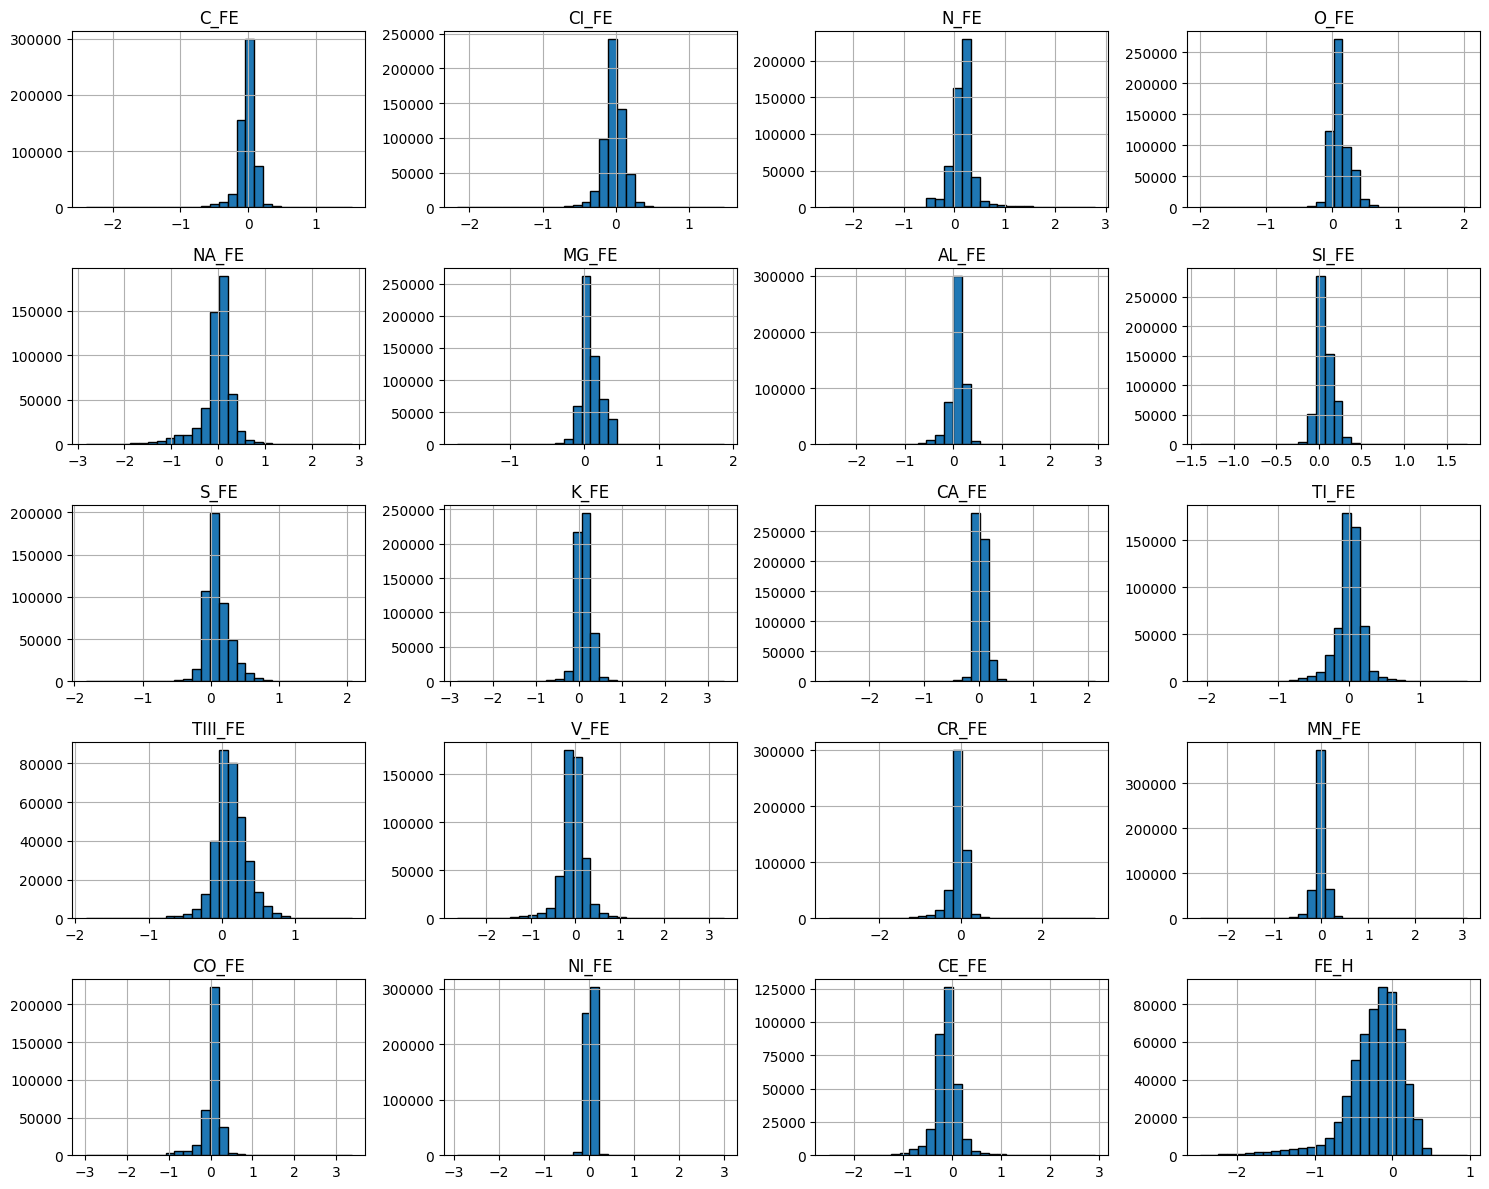

In [66]:
chemical_subset.hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


## Box plots (filtré)

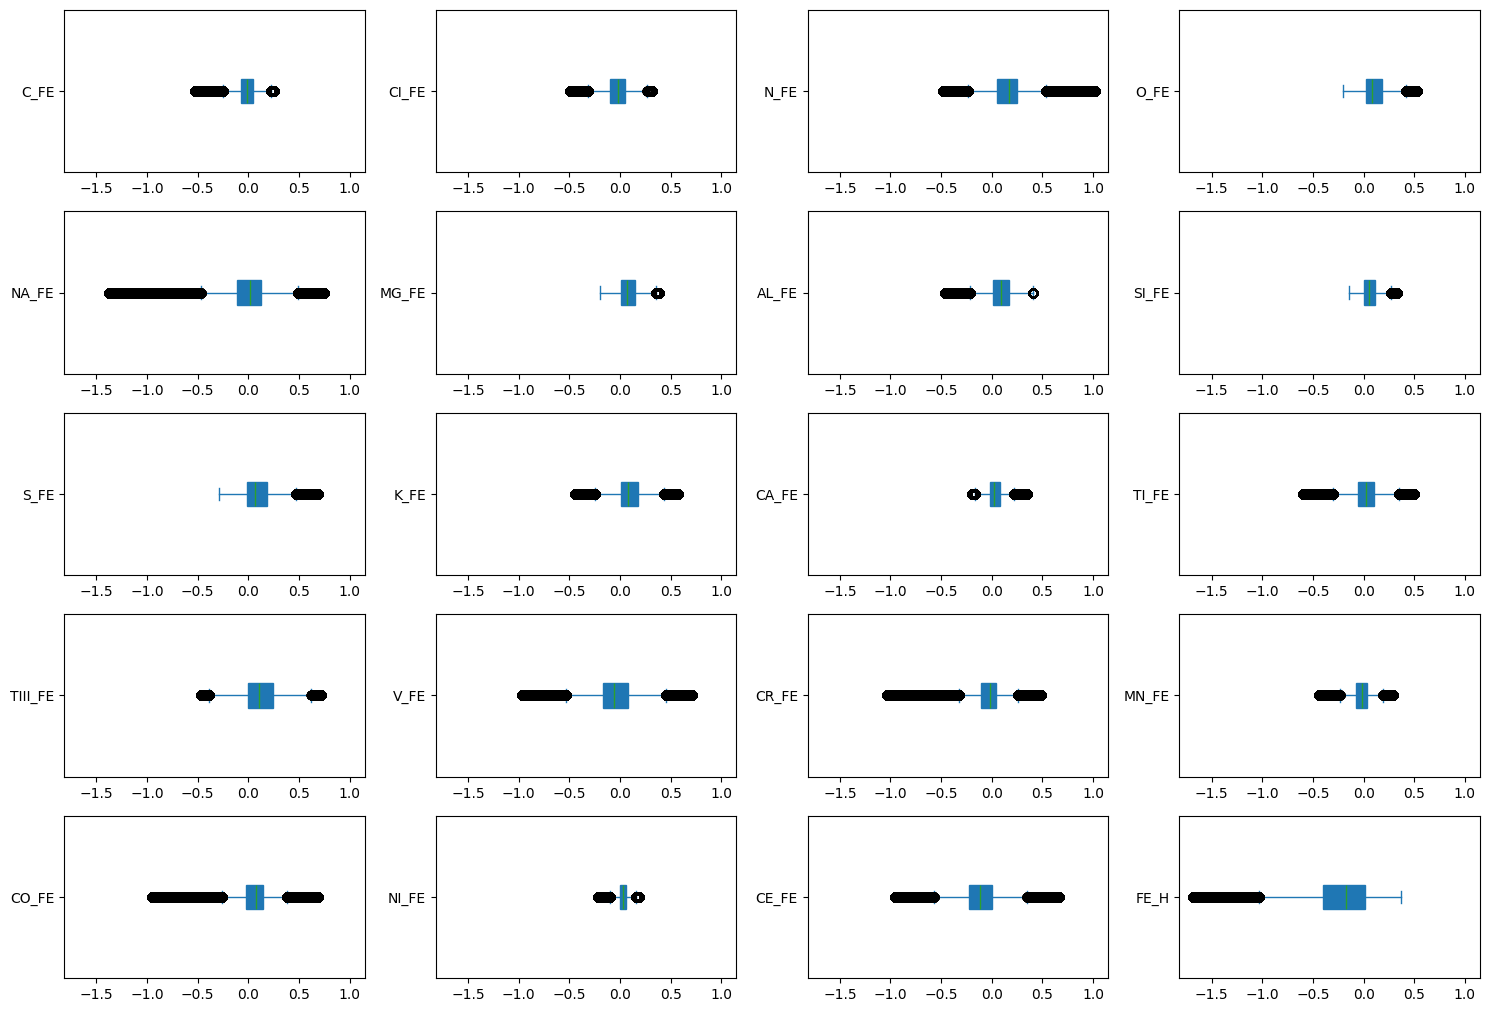

In [67]:
# Créer les boxplots en limitant les valeurs extrêmes
axes = chemical_subset_filtered.plot(kind='box', subplots=True, layout=(6, 4), figsize=(15, 12), patch_artist=True, vert=False)

# Si `axes` est une liste ou un tableau, on itère simplement dessus
for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=True)  # Afficher les étiquettes des axes x
    ax.yaxis.set_tick_params(labelleft=True)    # Afficher les étiquettes des axes y

# Rotation des étiquettes pour les rendre lisibles
plt.xticks(rotation=45)

# Ajuster l'espacement des sous-graphiques
plt.tight_layout()

# Afficher les boxplots
plt.show()



## Violin plots (filtré)

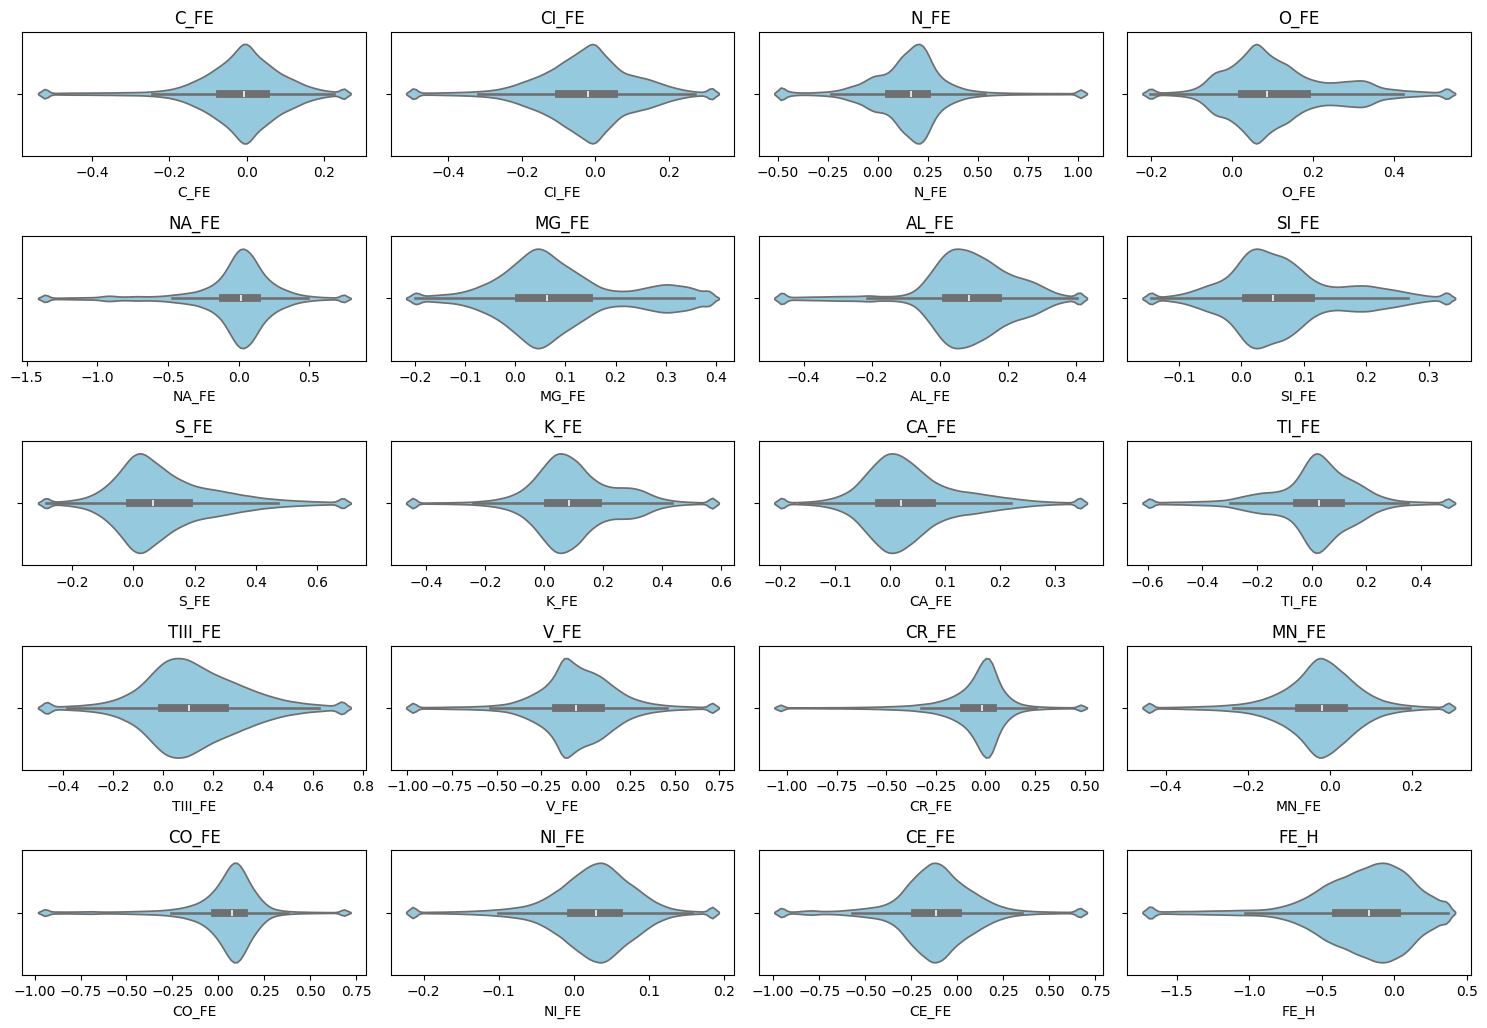

In [68]:
# Définir la taille de la figure
plt.figure(figsize=(15, 12))

# Créer un violin plot pour chaque colonne de chemical_subset
for i, column in enumerate(chemical_subset_filtered.columns, 1):
    plt.subplot(6, 4, i)
    sns.violinplot(x=chemical_subset_filtered[column], color='skyblue')
    plt.title(column)

# Ajuster l'espacement
plt.tight_layout()

# Afficher les violin plots
plt.show()


In [69]:
chemical_subset.corr(method='pearson', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.775270,-0.159406,0.252214,0.046694,0.362319,0.445123,0.250441,0.062609,0.186642,0.065615,0.289377,0.126202,0.039054,0.038077,0.096256,0.185771,0.314422,-0.067186,0.197560
CI_FE,0.775270,1.000000,-0.244846,0.390178,-0.002409,0.435927,0.438844,0.383961,0.189780,0.242129,0.186059,0.186151,0.210558,0.080407,-0.041455,-0.074892,0.130160,0.262178,-0.070679,-0.041714
N_FE,-0.159406,-0.244846,1.000000,-0.082207,0.137136,-0.074051,-0.062472,-0.022172,0.019549,0.009247,-0.049133,0.124094,-0.083781,0.003743,0.096730,0.115619,0.083267,0.009187,0.136021,-0.020640
O_FE,0.252214,0.390178,-0.082207,1.000000,-0.009377,0.738904,0.265468,0.701273,0.500585,0.358026,0.476452,0.234853,0.376313,0.100763,-0.027293,-0.388605,0.038219,0.202449,-0.140281,-0.496930
NA_FE,0.046694,-0.002409,0.137136,-0.009377,1.000000,0.068434,0.017175,0.005954,0.000902,0.069800,0.016941,0.111000,-0.050863,0.049655,0.133482,0.118546,0.148345,0.135732,-0.013068,0.042053
MG_FE,0.362319,0.435927,-0.074051,0.738904,0.068434,1.000000,0.416537,0.759079,0.549312,0.439870,0.530713,0.402674,0.421563,0.111599,0.069822,-0.316907,0.105814,0.295248,-0.128568,-0.454538
AL_FE,0.445123,0.438844,-0.062472,0.265468,0.017175,0.416537,1.000000,0.441321,0.078085,0.262573,0.241905,0.162055,0.268979,0.093179,-0.039414,-0.072549,0.063985,0.288627,-0.051787,0.073128
SI_FE,0.250441,0.383961,-0.022172,0.701273,0.005954,0.759079,0.441321,1.000000,0.484666,0.342226,0.470504,0.199105,0.402528,0.114492,-0.075600,-0.345251,0.071123,0.218106,-0.094193,-0.465324
S_FE,0.062609,0.189780,0.019549,0.500585,0.000902,0.549312,0.078085,0.484666,1.000000,0.318286,0.428256,0.189608,0.331609,0.029060,0.038785,-0.378183,0.009621,0.094571,-0.032181,-0.571459
K_FE,0.186642,0.242129,0.009247,0.358026,0.069800,0.439870,0.262573,0.342226,0.318286,1.000000,0.359472,0.249251,0.268134,0.084432,0.091754,-0.153002,0.110893,0.185851,-0.060075,-0.317890


In [70]:
chemical_subset.corr(method='kendall', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.617377,-0.155030,0.253950,0.082664,0.318957,0.286307,0.247629,0.175346,0.255696,0.097736,0.314999,0.137970,0.020214,0.059851,-0.052253,0.262582,0.326415,-0.211315,-0.012819
CI_FE,0.617377,1.000000,-0.255614,0.321880,0.034193,0.313849,0.349521,0.327832,0.216265,0.271266,0.157785,0.186435,0.195144,0.055372,-0.042876,-0.174223,0.210723,0.248829,-0.167245,-0.149451
N_FE,-0.155030,-0.255614,1.000000,-0.112885,0.132027,-0.099552,-0.148121,-0.102962,-0.025890,-0.032710,-0.114986,0.034412,-0.131579,-0.052743,0.089794,0.187685,0.031653,0.018447,0.107489,0.092878
O_FE,0.253950,0.321880,-0.112885,1.000000,-0.038621,0.577667,0.299889,0.546427,0.386794,0.334212,0.378633,0.225954,0.320799,0.071193,-0.059267,-0.357810,0.122124,0.231071,-0.116497,-0.378286
NA_FE,0.082664,0.034193,0.132027,-0.038621,1.000000,0.013955,0.015770,-0.016420,-0.032587,0.045544,-0.041939,0.098668,-0.038025,0.016171,0.089180,0.143008,0.160887,0.150874,-0.082730,0.129209
MG_FE,0.318957,0.313849,-0.099552,0.577667,0.013955,1.000000,0.344415,0.534911,0.428089,0.396313,0.442561,0.348483,0.313914,0.072665,0.044027,-0.339663,0.144163,0.308329,-0.144190,-0.363809
AL_FE,0.286307,0.349521,-0.148121,0.299889,0.015770,0.344415,1.000000,0.463933,0.147937,0.279802,0.298025,0.134502,0.253110,0.107421,-0.094126,-0.233569,0.095805,0.233832,-0.086498,-0.167837
SI_FE,0.247629,0.327832,-0.102962,0.546427,-0.016420,0.534911,0.463933,1.000000,0.313375,0.293740,0.370160,0.156740,0.329868,0.105574,-0.135762,-0.332529,0.108801,0.228104,-0.114499,-0.334439
S_FE,0.175346,0.216265,-0.025890,0.386794,-0.032587,0.428089,0.147937,0.313375,1.000000,0.325511,0.360634,0.186067,0.299657,0.009607,0.015255,-0.346023,0.059356,0.132118,-0.023460,-0.455196
K_FE,0.255696,0.271266,-0.032710,0.334212,0.045544,0.396313,0.279802,0.293740,0.325511,1.000000,0.350737,0.275844,0.257392,0.051191,0.042206,-0.259165,0.152076,0.211388,-0.111404,-0.294638


In [71]:
chemical_subset.corr(method='spearman', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.785805,-0.220542,0.367687,0.119502,0.458666,0.406488,0.359061,0.248224,0.364603,0.159448,0.446823,0.208387,0.029052,0.084951,-0.085831,0.363029,0.456142,-0.295207,-0.025805
CI_FE,0.785805,1.000000,-0.363328,0.456781,0.048600,0.450628,0.487766,0.464064,0.311911,0.390646,0.247771,0.275484,0.288067,0.080019,-0.065460,-0.256345,0.289728,0.352252,-0.235208,-0.216595
N_FE,-0.220542,-0.363328,1.000000,-0.155235,0.181778,-0.131443,-0.210919,-0.148749,-0.030917,-0.041695,-0.159683,0.060264,-0.185392,-0.076738,0.130246,0.265945,0.049165,0.030647,0.151869,0.133961
O_FE,0.367687,0.456781,-0.155235,1.000000,-0.053423,0.740621,0.414169,0.716260,0.533833,0.470195,0.522928,0.324008,0.455407,0.105351,-0.085417,-0.503541,0.168856,0.327561,-0.166831,-0.539495
NA_FE,0.119502,0.048600,0.181778,-0.053423,1.000000,0.022783,0.026051,-0.019999,-0.045872,0.066337,-0.056796,0.138387,-0.053801,0.021166,0.124825,0.198683,0.222246,0.213675,-0.116332,0.181520
MG_FE,0.458666,0.450628,-0.131443,0.740621,0.022783,1.000000,0.476441,0.701218,0.583953,0.549029,0.600580,0.485875,0.451699,0.108585,0.064241,-0.478050,0.206790,0.432842,-0.207490,-0.524935
AL_FE,0.406488,0.487766,-0.210919,0.414169,0.026051,0.476441,1.000000,0.603644,0.212211,0.396609,0.404387,0.202069,0.364101,0.154566,-0.136421,-0.314757,0.140477,0.331664,-0.123688,-0.220902
SI_FE,0.359061,0.464064,-0.148749,0.716260,-0.019999,0.701218,0.603644,1.000000,0.445399,0.424236,0.510958,0.236347,0.469865,0.153141,-0.196112,-0.468858,0.156773,0.324132,-0.164325,-0.473724
S_FE,0.248224,0.311911,-0.030917,0.533833,-0.045872,0.583953,0.212211,0.445399,1.000000,0.459921,0.508237,0.268368,0.423209,0.016875,0.026284,-0.487072,0.083054,0.188571,-0.035567,-0.628718
K_FE,0.364603,0.390646,-0.041695,0.470195,0.066337,0.549029,0.396609,0.424236,0.459921,1.000000,0.490841,0.394329,0.371126,0.075226,0.060560,-0.370870,0.216162,0.301364,-0.161840,-0.423188


In [72]:
chemical_subset.describe()

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
count,581069.000000,578260.000000,534862.000000,580686.000000,512486.000000,583092.000000,516553.000000,582982.000000,504789.000000,563787.000000,567469.000000,525304.000000,335233.000000,496826.000000,514347.000000,521088.000000,357998.000000,571186.000000,325767.000000,583735.000000
mean,-0.019626,-0.027672,0.156671,0.114176,-0.034561,0.087904,0.084443,0.066684,0.098981,0.096271,0.034481,0.012919,0.122559,-0.048933,-0.059051,-0.026106,0.034338,0.025038,-0.118441,-0.230730
std,0.136718,0.151325,0.231566,0.146948,0.357919,0.133874,0.162166,0.101036,0.182823,0.202528,0.108351,0.182004,0.217968,0.278083,0.242430,0.139702,0.263274,0.090735,0.269121,0.377859
min,-2.397020,-2.167200,-2.484940,-1.998207,-2.827178,-1.709735,-2.566144,-1.392327,-1.834437,-2.832461,-2.744315,-2.088917,-1.857361,-2.651900,-3.240002,-2.568998,-2.981460,-2.930750,-2.510510,-2.468600
25%,-0.068959,-0.098000,0.055836,0.025638,-0.110314,0.008419,0.016456,0.007844,-0.010665,0.011349,-0.020372,-0.054174,-0.005551,-0.163849,-0.106782,-0.074857,-0.017379,-0.003970,-0.226890,-0.401630
50%,-0.007573,-0.020405,0.168250,0.086229,0.019352,0.064173,0.085992,0.051234,0.063073,0.082399,0.020443,0.025512,0.104869,-0.054572,-0.017306,-0.020138,0.073749,0.029883,-0.115500,-0.171480
75%,0.049313,0.049642,0.247666,0.184204,0.129554,0.147236,0.170701,0.111461,0.182412,0.180819,0.076179,0.107733,0.246489,0.083677,0.038046,0.033416,0.142140,0.060823,0.003980,0.016160
max,1.529500,1.473540,2.791340,2.039563,2.847242,1.872143,2.931121,1.737151,2.074592,3.369369,2.137786,1.660383,1.774699,3.326362,3.309864,3.088052,3.374180,2.982033,2.913390,0.954290


In [73]:
# moyenne, écart-type, minimum, maximum, 1er quartile, médiane, 3e quartile
summary = chemical_subset.describe().loc[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
summary

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
mean,-0.019626,-0.027672,0.156671,0.114176,-0.034561,0.087904,0.084443,0.066684,0.098981,0.096271,0.034481,0.012919,0.122559,-0.048933,-0.059051,-0.026106,0.034338,0.025038,-0.118441,-0.230730
std,0.136718,0.151325,0.231566,0.146948,0.357919,0.133874,0.162166,0.101036,0.182823,0.202528,0.108351,0.182004,0.217968,0.278083,0.242430,0.139702,0.263274,0.090735,0.269121,0.377859
min,-2.397020,-2.167200,-2.484940,-1.998207,-2.827178,-1.709735,-2.566144,-1.392327,-1.834437,-2.832461,-2.744315,-2.088917,-1.857361,-2.651900,-3.240002,-2.568998,-2.981460,-2.930750,-2.510510,-2.468600
max,1.529500,1.473540,2.791340,2.039563,2.847242,1.872143,2.931121,1.737151,2.074592,3.369369,2.137786,1.660383,1.774699,3.326362,3.309864,3.088052,3.374180,2.982033,2.913390,0.954290
25%,-0.068959,-0.098000,0.055836,0.025638,-0.110314,0.008419,0.016456,0.007844,-0.010665,0.011349,-0.020372,-0.054174,-0.005551,-0.163849,-0.106782,-0.074857,-0.017379,-0.003970,-0.226890,-0.401630
50%,-0.007573,-0.020405,0.168250,0.086229,0.019352,0.064173,0.085992,0.051234,0.063073,0.082399,0.020443,0.025512,0.104869,-0.054572,-0.017306,-0.020138,0.073749,0.029883,-0.115500,-0.171480
75%,0.049313,0.049642,0.247666,0.184204,0.129554,0.147236,0.170701,0.111461,0.182412,0.180819,0.076179,0.107733,0.246489,0.083677,0.038046,0.033416,0.142140,0.060823,0.003980,0.016160


In [74]:
list(chemical_subset.columns)

['C_FE',
 'CI_FE',
 'N_FE',
 'O_FE',
 'NA_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'S_FE',
 'K_FE',
 'CA_FE',
 'TI_FE',
 'TIII_FE',
 'V_FE',
 'CR_FE',
 'MN_FE',
 'CO_FE',
 'NI_FE',
 'CE_FE',
 'FE_H']

In [75]:
variable_selection = ["J", "H", "K","LOGG", "M_H", "VMICRO", "VMACRO", "VSINI", 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'S_FE', 'K_FE', 'CA_FE', 
    'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE', 'FE_H']

In [76]:
sample = df[variable_selection]

In [81]:
print("nombre de lignes du dataset sample : ", sample.shape[0])

nombre de lignes du dataset sample :  657135


In [77]:
sample.head()

,J,H,K,LOGG,M_H,VMICRO,VMACRO,VSINI,C_FE,CI_FE,...,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
0,99.999001,99.999001,99.999001,4.428520,0.005657,0.412648,0.000000,4.778923,0.004847,0.011280,...,-0.016829,-0.231476,NaN,0.094248,-0.025774,0.040870,NaN,0.051278,NaN,0.003463
1,8.597000,7.667000,7.314000,0.904598,-0.147680,1.712182,3.223484,NaN,0.009295,-0.006826,...,-0.098512,NaN,NaN,-0.108158,NaN,NaN,0.07509,0.007683,NaN,-0.160680
2,11.074000,10.740000,10.670000,4.304115,-0.268750,0.409694,0.000000,6.273645,0.061738,0.070630,...,0.097266,0.112659,NaN,0.050501,-0.130982,-0.078027,NaN,0.013930,NaN,-0.275530
3,10.905000,10.635000,10.483000,3.673970,-0.245100,2.143433,0.000000,14.965801,0.112730,0.124440,...,-0.129135,0.170519,NaN,-0.005469,-1.112472,0.063633,NaN,-0.108750,NaN,-0.252970
5,15.008000,14.352000,14.277000,1.498851,-1.183200,1.381402,5.908144,NaN,-0.290710,NaN,...,-0.333875,-0.316947,NaN,0.186762,0.640534,-0.156498,0.02097,-0.038208,-0.15516,-1.171400


In [87]:
# Check for missing values
missing_values = sample.isnull().sum()

In [88]:
# Ordonner la liste des valeurs manquantes dans l'ordre croissant
missing_values_sorted = missing_values.sort_values()
print("Nombre de valeurs manquantes dans chaque colonne (ordre croissant):\n", missing_values_sorted)

Nombre de valeurs manquantes dans chaque colonne (ordre croissant):
 H              13
J            8785
K            8792
LOGG        38146
VMICRO      38146
VMACRO      38146
FE_H        73400
M_H         73428
MG_FE       74043
SI_FE       74153
C_FE        76066
O_FE        76449
CI_FE       78875
NI_FE       85949
CA_FE       89666
K_FE        93348
N_FE       122273
TI_FE      131831
MN_FE      136047
AL_FE      140582
CR_FE      142788
NA_FE      144649
S_FE       152346
V_FE       160309
CO_FE      299137
TIII_FE    321902
CE_FE      331368
VSINI      383422
dtype: int64


In [89]:
missing_values_dropable = missing_values[missing_values > sample.shape[0]/3]

In [90]:
missing_values_dropable

VSINI      383422
TIII_FE    321902
CO_FE      299137
CE_FE      331368
dtype: int64

In [86]:
# Number of rows with any missing values
num_rows_with_missing = sample.isnull().any(axis=1).sum()
print("Number of rows with missing values:", num_rows_with_missing, "/", sample.shape[0])

Number of rows with missing values: 627565 / 657135


In [105]:
print("Nombre de colonnes du dataset sample : ", sample.shape[1])

Nombre de colonnes du dataset sample :  28


In [94]:
missing_per_row = sample.isna().sum(axis=1)

In [97]:
#retire les lignes avec aucunes valeurs manquantes de missing_per_row
missing_per_row = missing_per_row[missing_per_row > 0]

In [98]:
print("Nombre de valeurs manquantes par ligne (ordre croissant):\n", missing_per_row.sort_values())

Nombre de valeurs manquantes par ligne (ordre croissant):
 733891     1
733879     1
733880     1
597149     1
46         1
          ..
195895    28
196002    28
196185    28
196590    28
4412      28
Length: 627565, dtype: int64


In [101]:
#compte le nombre de ligne par nombre de valeurs manquantes
# trié par ordre croissant
missing_per_row.value_counts().sort_index()

1     279966
2      20981
3     121194
4      36141
5      15765
6       9360
7       2016
8       8775
9      18974
10     15252
11      6260
12      8089
13      7073
14      4097
15       143
16        68
17         8
18         1
19         2
20        42
21     34215
22       442
23       511
24        44
25     34550
26         1
27      3582
28        13
Name: count, dtype: int64